# **Zur Bearbeitung der Progammier-Aufgabe 7 im Modul ML&AI Fundamentals**

--> Make shure you have correctly installed PyTorch on your device

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# Import util functions
from utils_v2 import make_spiral 
from utils_v2 import plot_data, plot_data_and_decision_boundary, draw_mlp_network, plot_training_progress, plot_decision_boundary_roundwise

### **Generate the Dataset**

/Users/felix/Documents/education/dhbw/04-sose_25/ai_and_ml/programming/WDSKI_SOSE-Applied_ML_Fundamentals/exercise_6/utils_v2.py:38: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolor='k', marker='x')


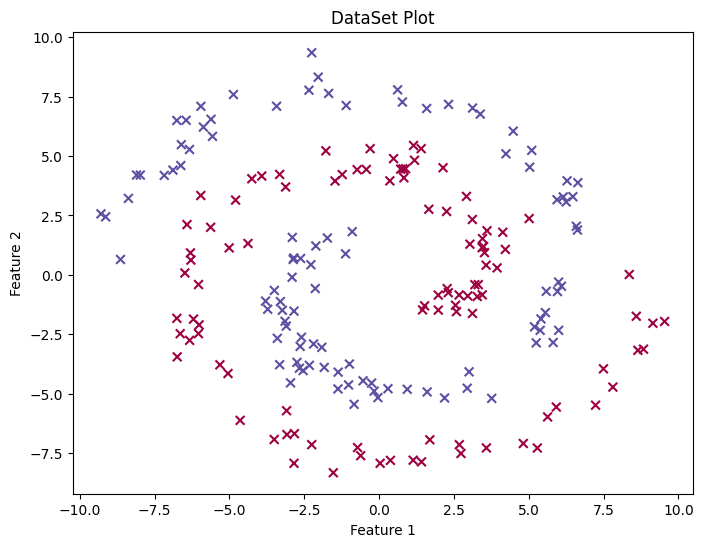

In [3]:
# Generate and plot the dataset
X, y = make_spiral(n_samples=100)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
plot_data(X, y)

### **Setting Up PyTorch**

<div class="alert alert-block alert-success">
<b>Up to you:</b> Using the correct Resources for Trining could improve the Trainin Speed and Performance of the Model.
</div>

In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


# **Q1:**
*Implement and train a neural network on the dataset generated above. You are free to use any network architecture you think is useful. Finally, plot the decision boundary generated by your model.*

<div class="alert alert-block alert-info">

**The training of a neural network can be devided into the following steps:**
1. Initialization of the parameters W[1], b[1], W[2], b[2], . . .
2. Computation of the forward pass
(i. e. compute the activations of the network for a batch of training examples)
3. Evaluate the loss function based on the true labels
4. Propagate the error gradients backwards through the network and update the
parameters (this step is referred to as backpropagation)
5. Update the weights using the gradient descent update rule

-> Steps (2) to (5) are repeated until the network performs satisfactorily or until a fixed
number of iterations specified in advance has been performed

<div>

### **How to use PyTorch correctly?**

In PyTorch Datasets and Dataloader can be used for better Performance:

**Dataset-Klasse:**
- Diese Klasse dient dazu, den Datensatz in einer Art Container zu verpacken, den PyTorch dann verarbeiten kann.
- Die Klasse SpiralDataset erbt von torch.utils.data.Dataset, einer abstrakten Klasse, die genau die zwei Methoden __len__() und __getitem__() implementiert.
- __init__() wird verwendet, um die Daten (Features X und Labels y) zu speichern, wobei sie in Torch-Tensoren umgewandelt werden, was notwendig ist, um sie in PyTorch weiter bearbeiten zu können.
- __len__() gibt die Anzahl der Datenpunkte im Datensatz zurück.
- __getitem__() gibt einen einzelnen Datenpunkt zurück, bestehend aus einem Feature-Vektor und einem Label, basierend auf einem gegebenen Index.

**DataLoader:**
- Der DataLoader ist verantwortlich für das Laden von Daten in Batches und das Shufflen der Daten, falls erwünscht.
- PyTorch's *DataLoader* übernimmt die Aufgabe, die Daten effizient zu laden und stapelweise zu verarbeiten, wodurch das Training beschleunigt wird.
- *DataLoader(dataset, batch_size=32, shuffle=True)* erstellt einen DataLoader, der die Daten aus dem dataset in Batches von 32 Beispielpunkten lädt und die Daten vor jedem Epoche-Training mischt.

In [5]:
# Define Dataset and DataLoader
class SpiralDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SpiralDataset(X, y)
dataloader = DataLoader(dataset, batch_size=300, shuffle=True) # Bacht size of 1 -> Stochastic Gradient Descent (SGD)

### **Design the Model and intialize the Parameters**


1. The Parameters are inititalized normal-ditributet around 0

2. PyTorch provides two different ways of initalizing a NN:
    1. By Hand
    2. As a **Sequential** -- Eine alternative Methode ist die Verwendung von nn.Sequential, um eine Pipeline-Architektur zu definieren. nn.Sequential erlaubt es, die Layer eines Modells in der Reihenfolge zu spezifizieren, in der die Daten durch diese fließen, ohne eine explizite forward()-Methode zu definieren:

In [6]:
# Define the Neural Network Architecture
class First_NeuralNetwork(nn.Module):
    def __init__(self):
        super(First_NeuralNetwork, self).__init__()
        self.hidden_layer_1 = nn.Linear(2, 10)
        self.hidden_layer_2 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 2)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

        # Initialize weights with normal distribution
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.softmax(self.output_layer(x))
        return x

In [7]:
# Instantiate the model
first_model = First_NeuralNetwork()

#### Take a look at the model

In [8]:
# Show the network parameters
for name, param in first_model.named_parameters():
    print(f"\n parameters for {name}:\n", param.data)


 parameters for hidden_layer_1.weight:
 tensor([[ 0.0615, -0.1222],
        [ 0.0116,  0.1244],
        [-0.0444, -0.1776],
        [-0.0345,  0.0946],
        [-0.0397, -0.0145],
        [ 0.0867,  0.0229],
        [ 0.0494,  0.0929],
        [ 0.0155,  0.1508],
        [ 0.1800,  0.0349],
        [-0.1072,  0.0507]])

 parameters for hidden_layer_1.bias:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

 parameters for hidden_layer_2.weight:
 tensor([[ 0.1359,  0.0732,  0.1808, -0.0862,  0.1182, -0.0539, -0.0154,  0.0617,
          0.0708,  0.0530],
        [-0.1559, -0.0475,  0.0281,  0.1124, -0.0370,  0.0964,  0.0460,  0.0897,
         -0.0167, -0.1636],
        [-0.1428, -0.0679,  0.0265, -0.0237, -0.1466,  0.0501, -0.1749, -0.0435,
          0.0300,  0.0267],
        [-0.0384, -0.2891, -0.0556, -0.0143, -0.0521, -0.0145,  0.0275, -0.0403,
         -0.2417, -0.0635],
        [ 0.0049, -0.0191,  0.0581, -0.0382,  0.2002,  0.0156, -0.0617,  0.0490,
         -0.0247,  0.0648],
    

### **Perform a singel forward Pass:**

**To Do:**
-> explain what a forward Pass is and how to perform it with PyTorch

In [9]:
# Perfrom one forward pass to check the model:
with torch.no_grad():
    sample_input = torch.tensor(X[:5], dtype=torch.float32)
    sample_output = first_model(sample_input)
    labels = torch.argmax(sample_output, dim=1)
    #criterion_output = criterion(sample_output, torch.tensor([0], dtype=torch.long))
    print(f"Sample input:\n{sample_input} \n \n Sample output:\n {sample_output}\n \n Resulting Label:  {labels}" )#, Loss: {criterion_output.item()}")

Sample input:
tensor([[-1.7769,  5.2217],
        [ 8.6473, -3.1784],
        [-2.2482, -7.1489],
        [-6.6416, -2.4775],
        [ 4.2191,  1.0704]]) 
 
 Sample output:
 tensor([[0.4976, 0.5024],
        [0.4920, 0.5080],
        [0.4961, 0.5039],
        [0.4996, 0.5004],
        [0.4992, 0.5008]])
 
 Resulting Label:  tensor([1, 1, 1, 1, 1])


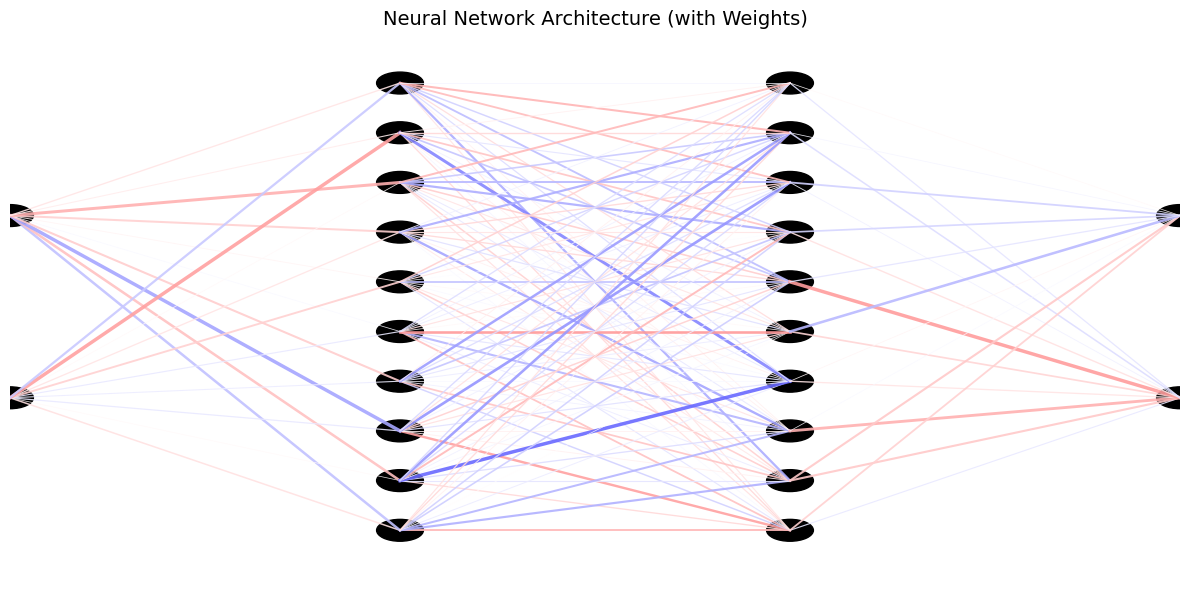

In [10]:
draw_mlp_network(first_model, show_weights=True)

/Users/felix/Documents/education/dhbw/04-sose_25/ai_and_ml/programming/WDSKI_SOSE-Applied_ML_Fundamentals/exercise_6/utils_v2.py:62: UserWarning: You passed a edgecolor/edgecolors ('g') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolor='g', marker='x')


<Axes: title={'center': 'Decision Boundary'}, xlabel='Feature 1', ylabel='Feature 2'>

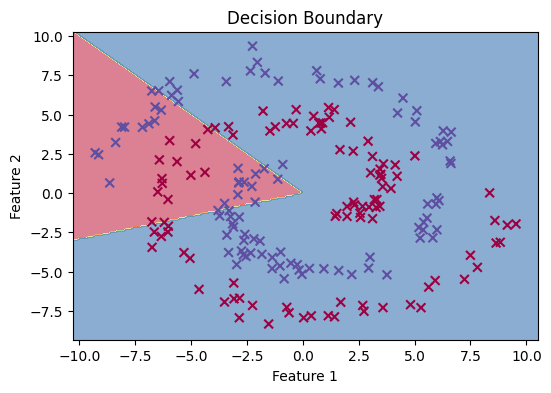

In [11]:
plot_data_and_decision_boundary(first_model, X, y)

### **Perform a Backpropagation**

**To Do:**
-> explain what a Back-Propagation is and how to perform it with PyTorch

Output logits:
 tensor([[0.5036, 0.4964],
        [0.4992, 0.5008],
        [0.4969, 0.5031],
        [0.4941, 0.5059],
        [0.4969, 0.5031],
        [0.4974, 0.5026],
        [0.4994, 0.5006],
        [0.4901, 0.5099],
        [0.4984, 0.5016],
        [0.5023, 0.4977],
        [0.4934, 0.5066],
        [0.4972, 0.5028],
        [0.4968, 0.5032],
        [0.4987, 0.5013],
        [0.4994, 0.5006],
        [0.5018, 0.4982],
        [0.4981, 0.5019],
        [0.4992, 0.5008],
        [0.4996, 0.5004],
        [0.4978, 0.5022],
        [0.5027, 0.4973],
        [0.5029, 0.4971],
        [0.4977, 0.5023],
        [0.4976, 0.5024],
        [0.4993, 0.5007],
        [0.4945, 0.5055],
        [0.4982, 0.5018],
        [0.4974, 0.5026],
        [0.5006, 0.4994],
        [0.4927, 0.5073],
        [0.5027, 0.4973],
        [0.4989, 0.5011],
        [0.4980, 0.5020],
        [0.4949, 0.5051],
        [0.5008, 0.4992],
        [0.4961, 0.5039],
        [0.4876, 0.5124],
        [0.4997, 0.500

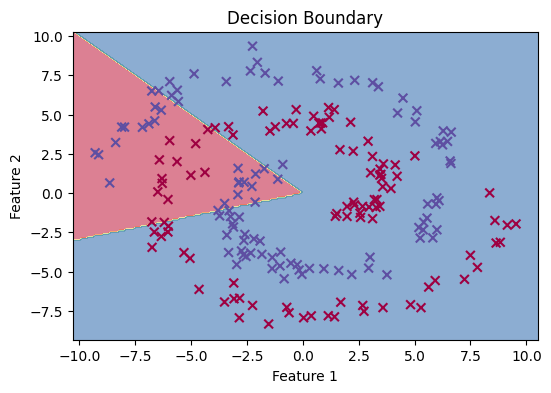

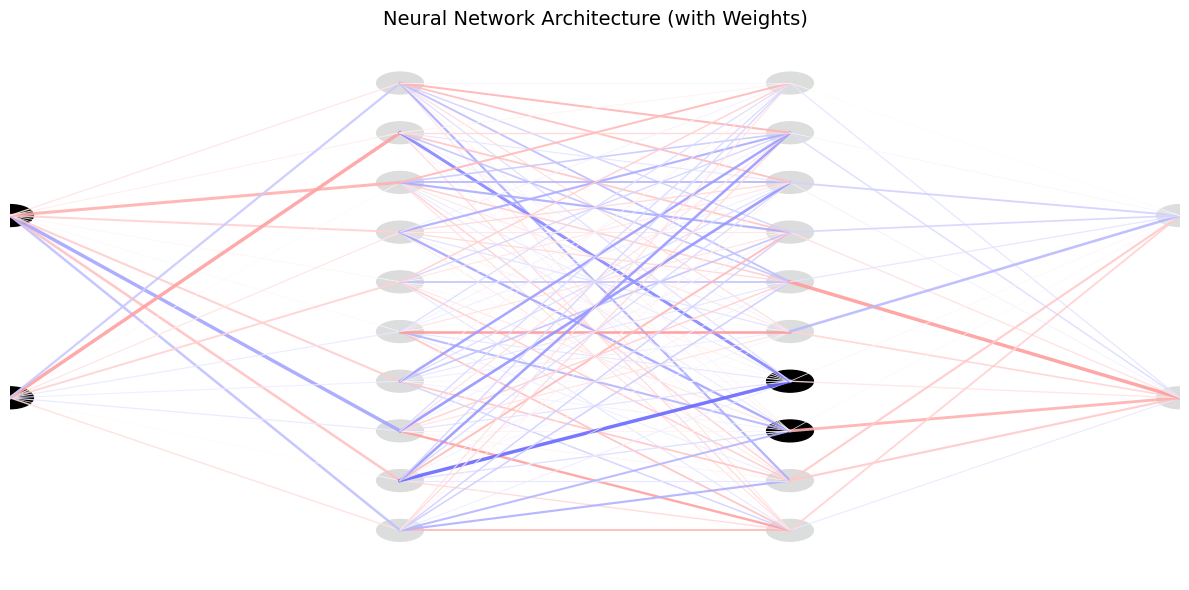

In [12]:
batch_X, batch_y = next(iter(dataloader))

# Perform a single forward pass
output_logits = first_model(batch_X)
print("Output logits:\n", output_logits)

# Calculate the loss
criterion = nn.CrossEntropyLoss()
loss = criterion(output_logits, batch_y)
print("\nLoss:\n", loss.item())

# Compute gradients (backward pass)
first_model.zero_grad()  # Clear previous gradients
loss.backward()    # Compute gradients

# Display gradients for each layer
for name, param in first_model.named_parameters():
    if param.requires_grad:
        print(f"\nGradients for {name}:\n", param.grad)

# Update Weights
# Normally done by optimizer, here for visualization only

learning_rate = 0.01
with torch.no_grad():
    for param in first_model.parameters():
        param -= learning_rate * param.grad

# Show updated parameters
for name, param in first_model.named_parameters():
    print(f"\nUpdated parameters for {name}:\n", param.data)

plot_data_and_decision_boundary(first_model, X, y)
draw_mlp_network(first_model, show_weights=True)

### **Itterate the Training-processes**

--> now itterating the steps

In [13]:
# Funktion to perform the training of the model
def train_model(model, learning_rate=0.01, optimizer_fn=optim.Adam, loss_fn=nn.CrossEntropyLoss, num_epochs=100, plot_interval=10):
    criterion = loss_fn()
    optimizer = optimizer_fn(model.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []

    # Set up for plotting
    num_plots = num_epochs // plot_interval
    fig, axes = plt.subplots(nrows=num_plots//2, ncols=2, figsize=(12, 6 * (num_plots//2)))

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0

        for batch_X, batch_y in dataloader:
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                predictions = torch.argmax(y_pred, dim=1)
                correct += (predictions == batch_y).sum().item()

        train_loss.append(epoch_loss / len(dataloader))
        accuracy = correct / len(dataset)
        train_acc.append(accuracy * 100)

        if (epoch + 1) % plot_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss[-1]:.4f}, Accuracy: {train_acc[-1]:.2f}%")
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            plot_decision_boundary_roundwise(model, X_tensor, y_tensor, ax=ax1)
            ax1.set_title(f"Decision Boundary (Epoch {epoch+1})")

            draw_mlp_network(
                model,
                #architecture_dict=architectures[0]['model_params'],
                show_weights=True,
                ax=ax2
            )

            plt.tight_layout()
            plt.show()
            

    # Plot final metrics with dual axes
    fig, ax1 = plt.subplots(figsize=(8, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color=color)
    ax1.plot(train_loss, color=color, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Train Accuracy (%)', color=color)
    ax2.plot(train_acc, color=color, label='Train Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and legends
    fig.suptitle('Training Loss and Accuracy')
    fig.tight_layout()  # For a cleaner layout
    plt.show()

    return model

Epoch [100/1000], Loss: 0.6434, Accuracy: 64.50%


/Users/felix/Documents/education/dhbw/04-sose_25/ai_and_ml/programming/WDSKI_SOSE-Applied_ML_Fundamentals/exercise_6/utils_v2.py:176: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Spectral, s=40, marker='x')


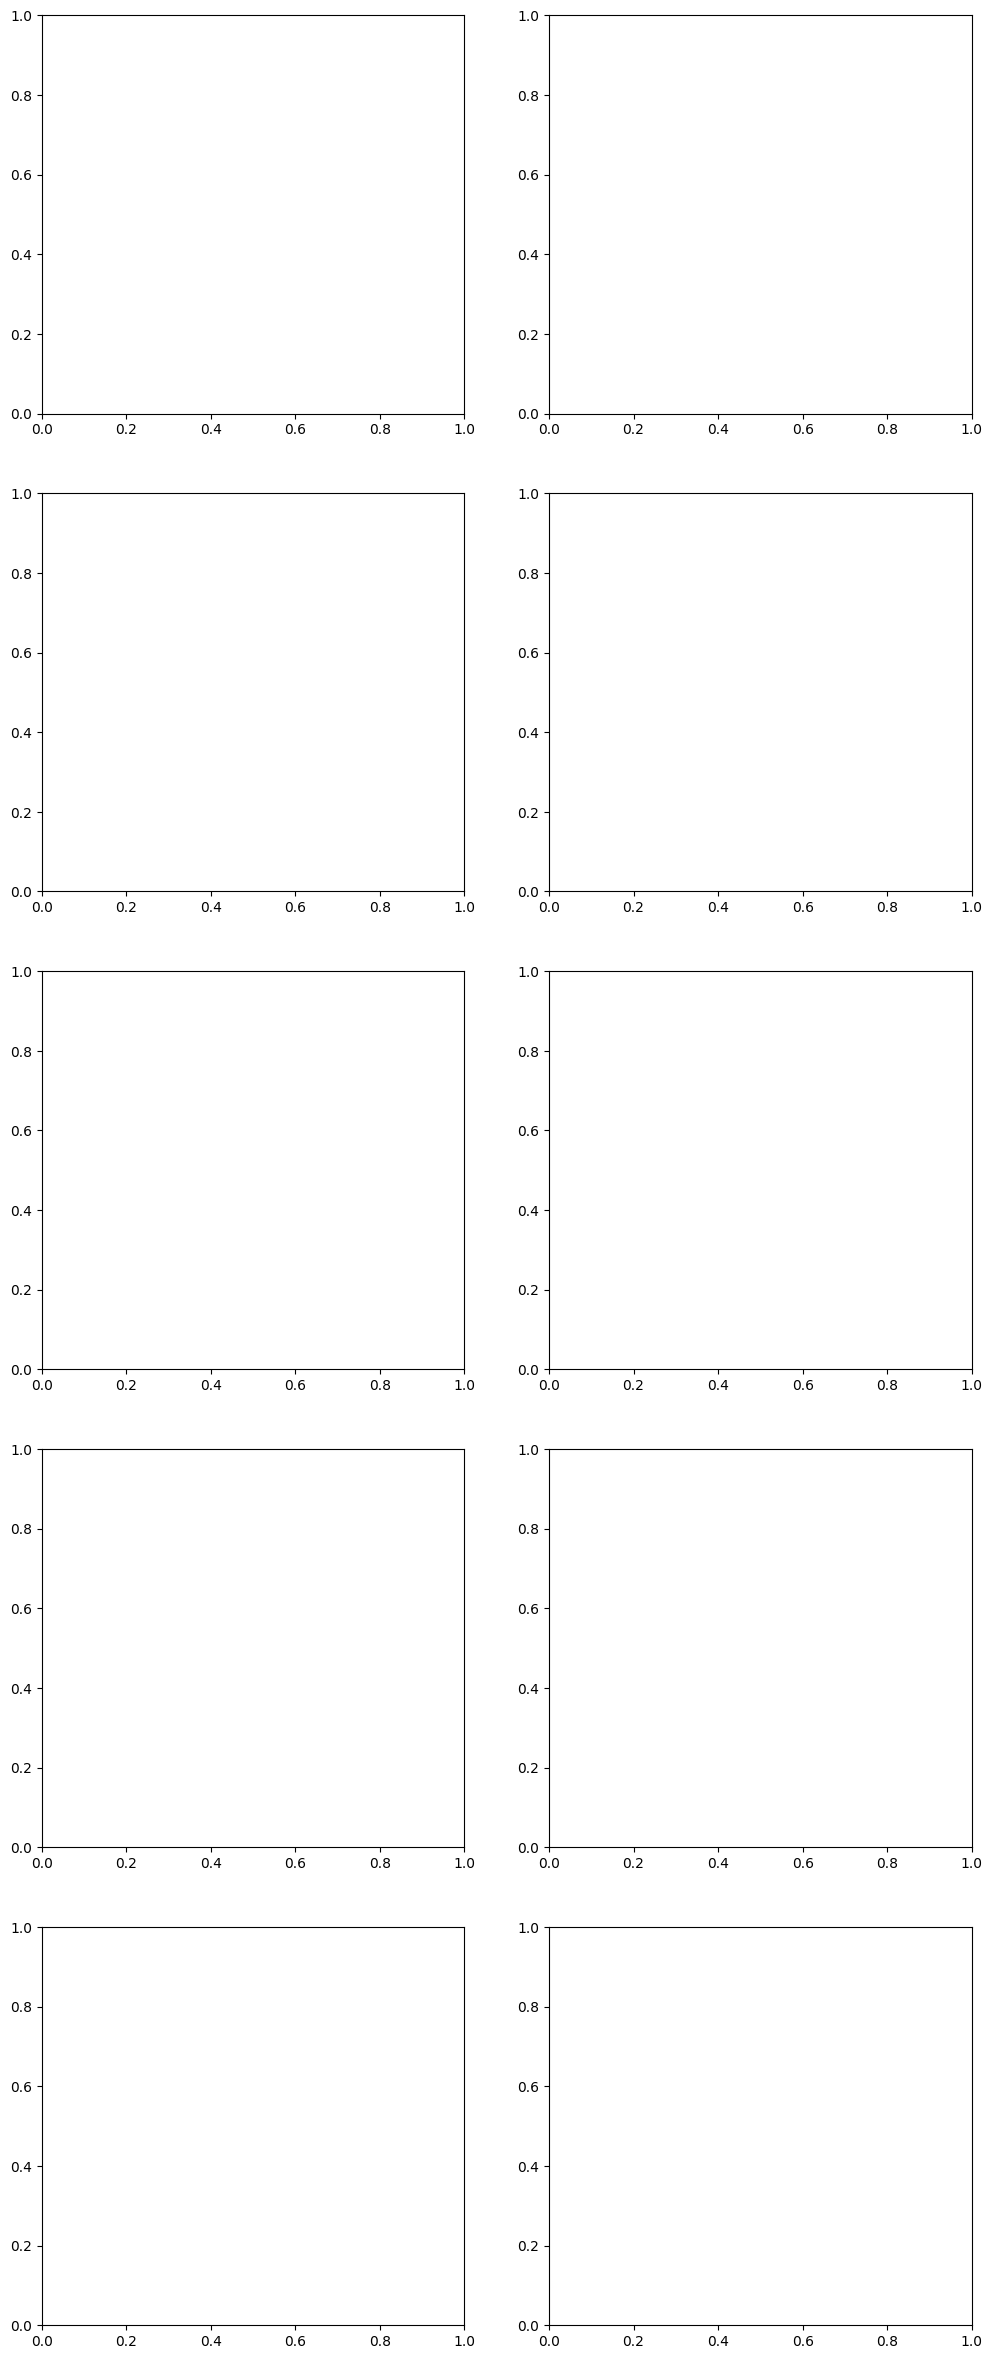

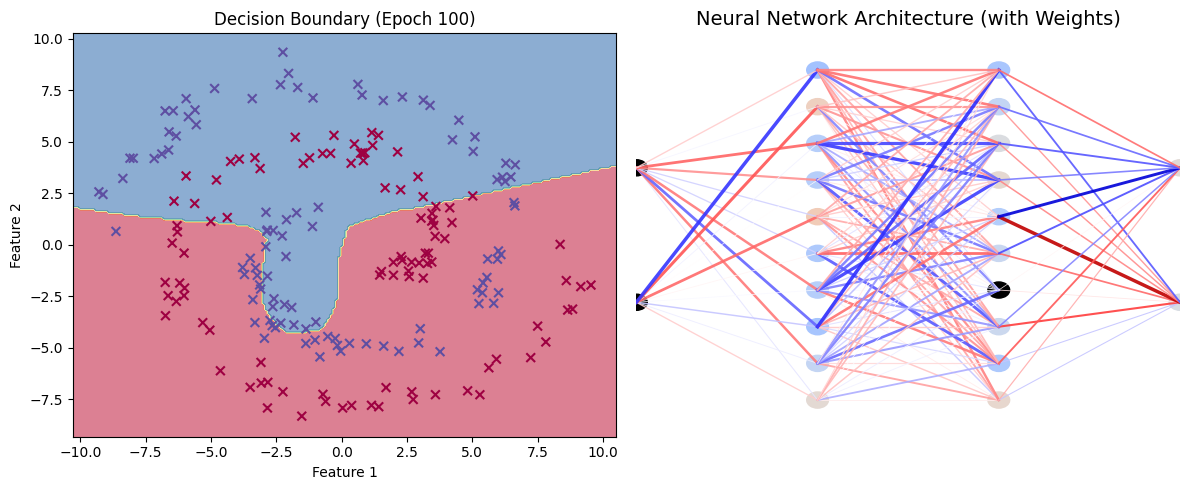

<Figure size 640x480 with 0 Axes>

Epoch [200/1000], Loss: 0.5452, Accuracy: 76.50%


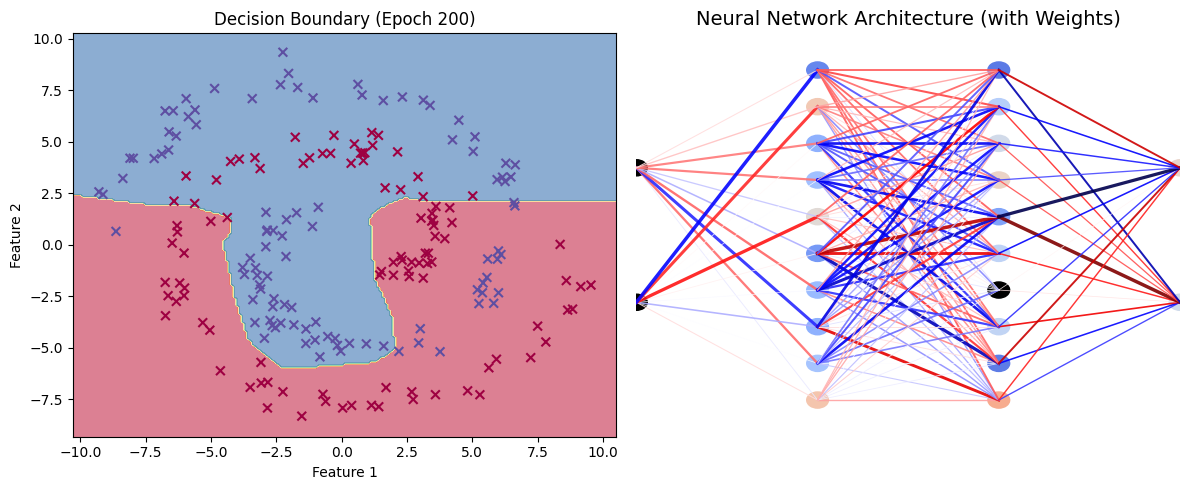

<Figure size 640x480 with 0 Axes>

Epoch [300/1000], Loss: 0.4368, Accuracy: 92.50%


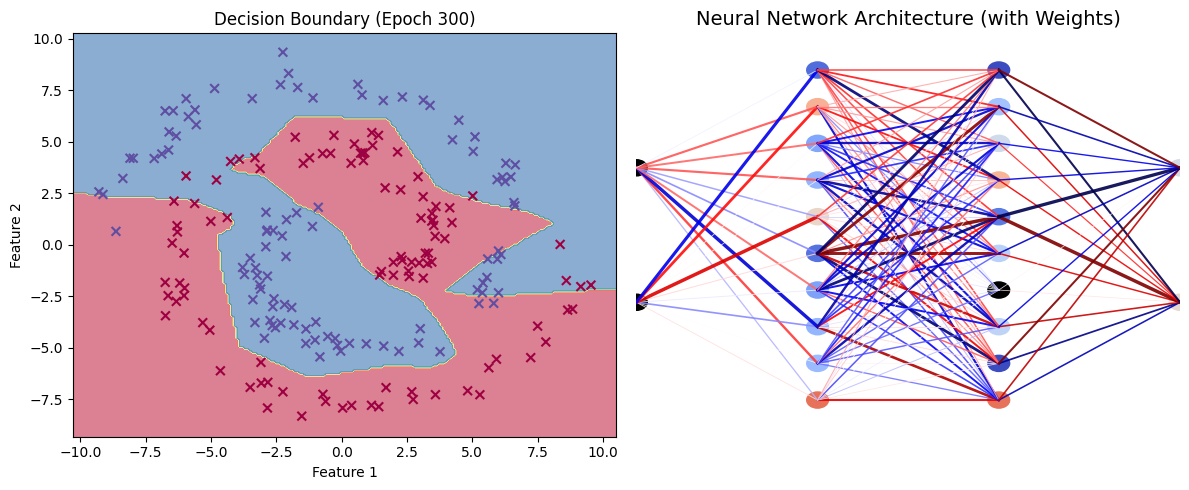

<Figure size 640x480 with 0 Axes>

Epoch [400/1000], Loss: 0.3911, Accuracy: 96.00%


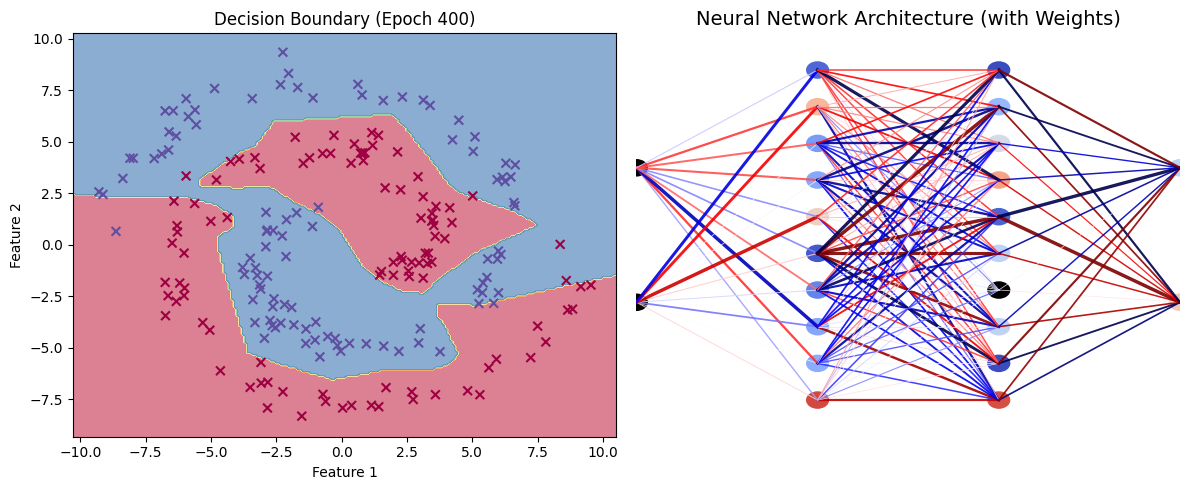

<Figure size 640x480 with 0 Axes>

Epoch [500/1000], Loss: 0.3684, Accuracy: 97.50%


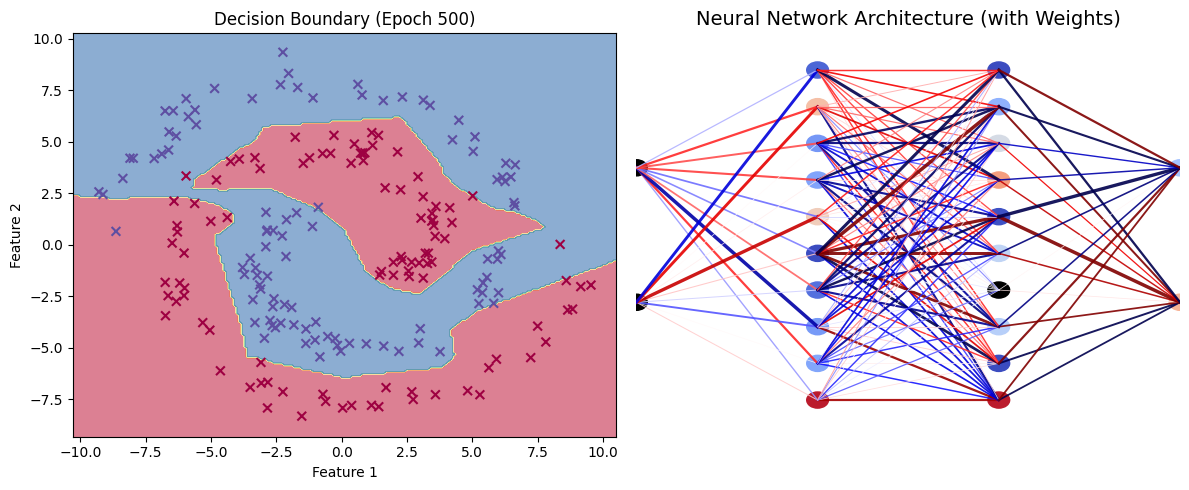

<Figure size 640x480 with 0 Axes>

Epoch [600/1000], Loss: 0.3628, Accuracy: 98.00%


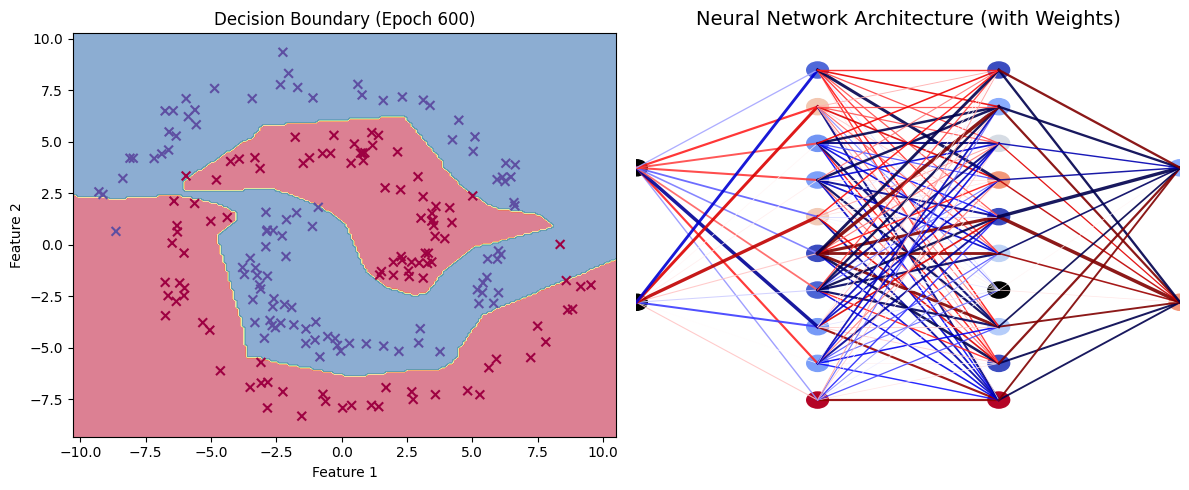

<Figure size 640x480 with 0 Axes>

Epoch [700/1000], Loss: 0.3482, Accuracy: 99.00%


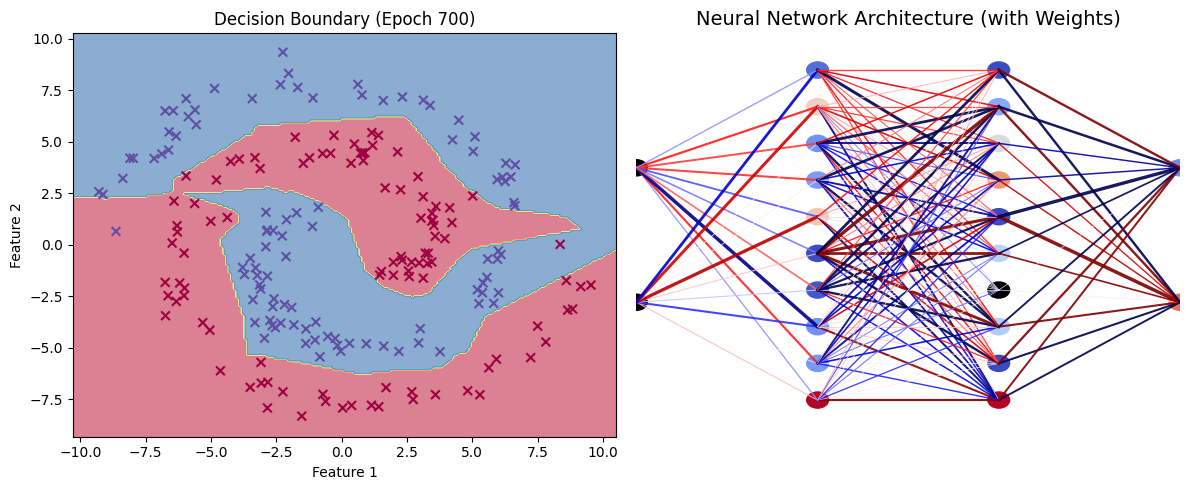

<Figure size 640x480 with 0 Axes>

Epoch [800/1000], Loss: 0.3412, Accuracy: 99.00%


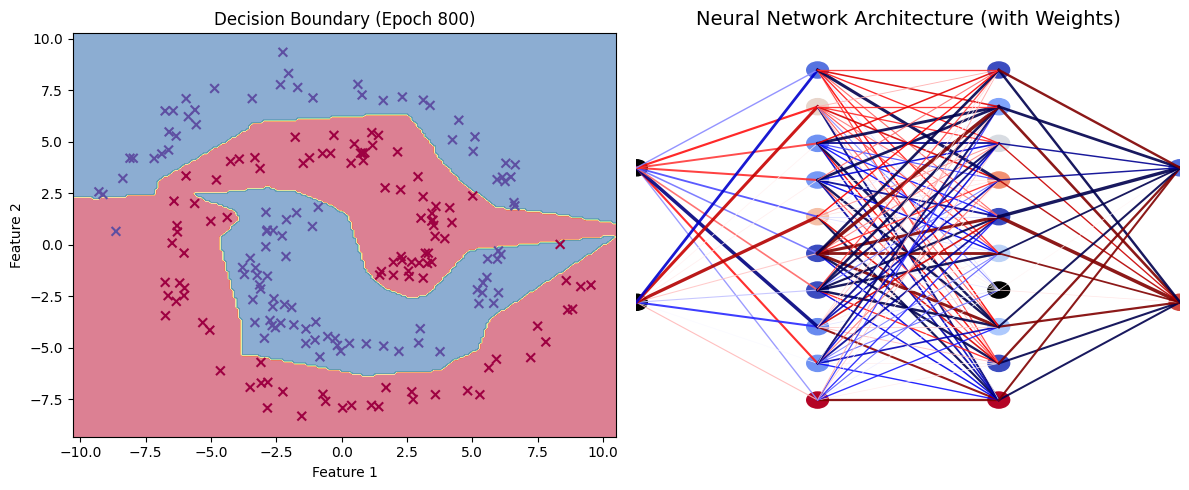

<Figure size 640x480 with 0 Axes>

Epoch [900/1000], Loss: 0.3341, Accuracy: 99.50%


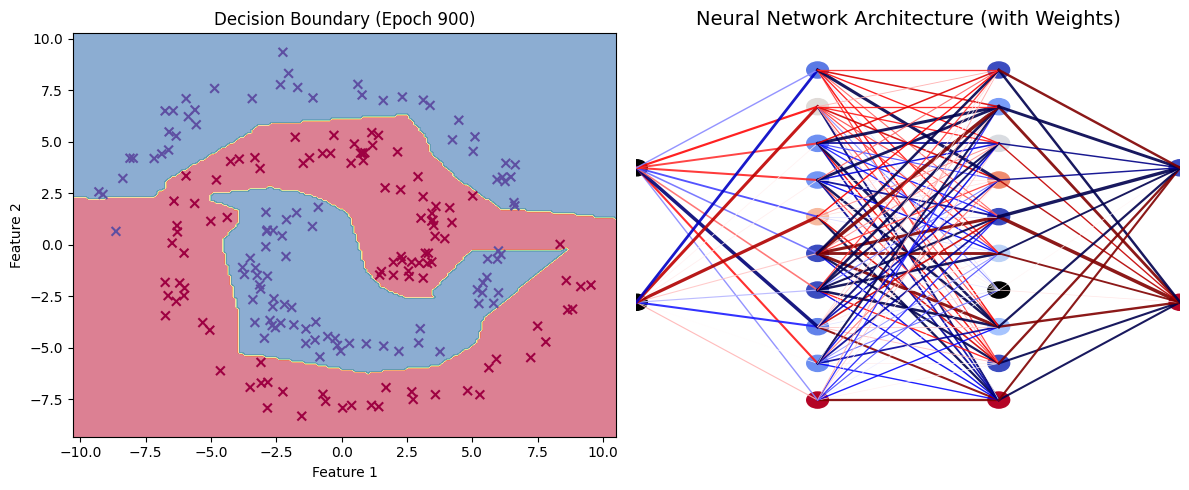

<Figure size 640x480 with 0 Axes>

Epoch [1000/1000], Loss: 0.3269, Accuracy: 99.50%


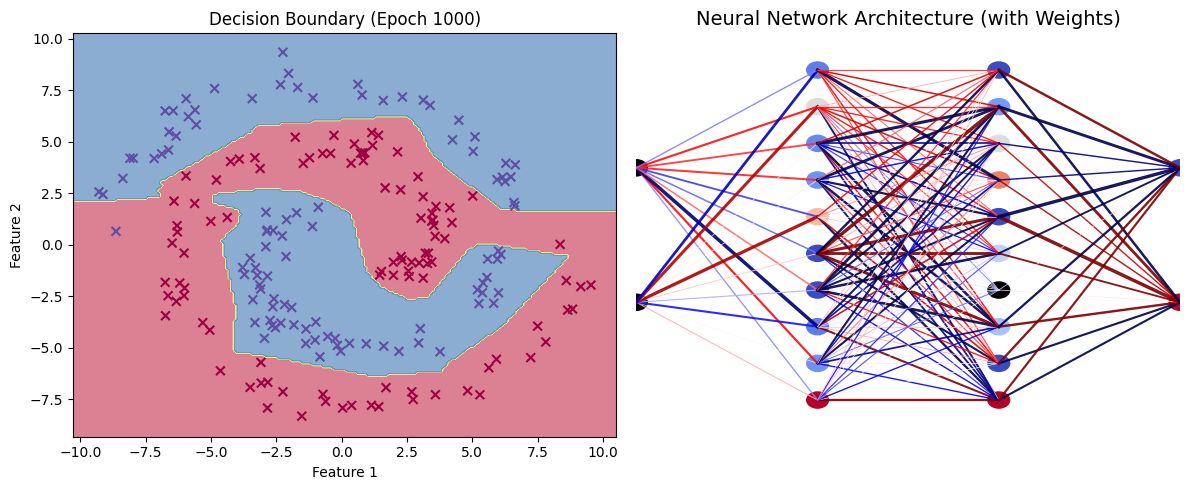

<Figure size 640x480 with 0 Axes>

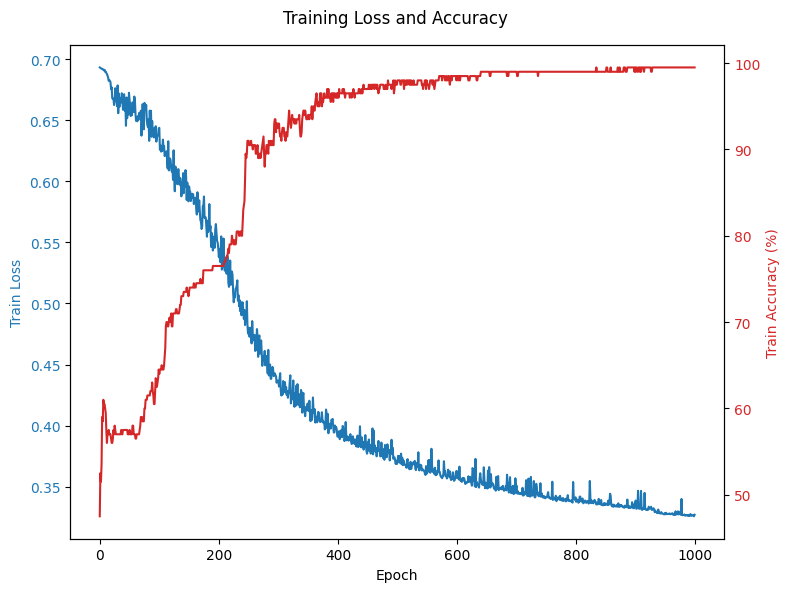

In [14]:
# Example for training the model with parameterized inputs
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # Bacht size of 1 -> Stochastic Gradient Descent (SGD)

model = train_model(first_model, learning_rate=0.001, optimizer_fn=optim.Adam, loss_fn=nn.CrossEntropyLoss, num_epochs=1000, plot_interval=100)

/Users/felix/Documents/education/dhbw/04-sose_25/ai_and_ml/programming/WDSKI_SOSE-Applied_ML_Fundamentals/exercise_6/utils_v2.py:62: UserWarning: You passed a edgecolor/edgecolors ('g') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolor='g', marker='x')


<Axes: title={'center': 'Decision Boundary'}, xlabel='Feature 1', ylabel='Feature 2'>

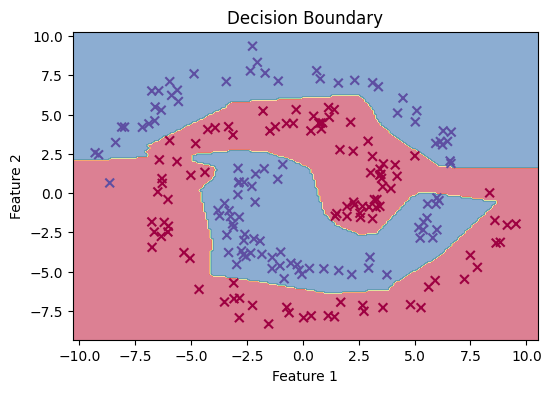

In [15]:
plot_data_and_decision_boundary(model, X, y)

# **Q2**
*Play around with the hyperparameters of your network (# hidden layers, # neurons, loss func-
tion, etc.) and see how this influences the decision boundary. Can you find a network archi-
tecture that classifies all training records correctly?*

#### *Helper Functions*
--> We therefore will implement a flexible way to define the Model:

In [16]:
from utils_v2 import FlexibleNeuralNetwork, train_flexible_model, compare_parameter_group, visualize_results

### **Defining diffenrent Models**

We can do this using this Format:
architectures = [
    {  
        'name': 'Flaches Netz [10]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    }
]

activation_functions = [
    {
        'name': 'ReLU',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    }
]

loss_functions = [
    {
        'name': 'CrossEntropy',
        'training_params': {
            'loss_fn': nn.CrossEntropyLoss,
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    }
]

In [17]:
# Definiere verschiedene Modellarchitekturen
architectures = [
    {
        'name': 'Flaches Netz [10]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Standard [10, 10]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Tief [10, 10, 10]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10, 10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Breit [20, 20]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [20, 20],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    }
]

# Definiere verschiedene Aktivierungsfunktionen
activation_functions = [
    {
        'name': 'ReLU',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Sigmoid',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.Sigmoid()
        }
    },
    {
        'name': 'Tanh',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.Tanh()
        }
    },
    {
        'name': 'LeakyReLU',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.LeakyReLU(0.1)
        }
    }
]

# Definiere verschiedene Optimierer und Lernraten
optimizers = [
    {
        'name': 'Adam LR=0.01',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'SGD LR=0.01',
        'training_params': {
            'optimizer_fn': optim.SGD,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'RMSprop LR=0.01',
        'training_params': {
            'optimizer_fn': optim.RMSprop,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'Adam LR=0.001',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.001,
            'batch_size': 32,
            'num_epochs': 200
        }
    }
]

loss_functions = [
    {
        'name': 'CrossEntropy',
        'training_params': {
            'loss_fn': nn.CrossEntropyLoss,
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },    
    {
        'name': 'MSE',
        'training_params': {
            'loss_fn': nn.MSELoss,
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
]

# Definiere verschiedene Batch-Größen
batch_sizes = [
    {
        'name': 'Batch Size=8',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 8,
            'num_epochs': 200
        }
    },
    {
        'name': 'Batch Size=32',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'Batch Size=64',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 64,
            'num_epochs': 200
        }
    },
    {
        'name': 'Full Batch',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': len(dataset),
            'num_epochs': 200
        }
    }
]

In [ ]:
# Example Training
model, history = train_flexible_model(architectures[0], loss_functions[0], dataset)

plot_data_and_decision_boundary(model, X, y)
draw_mlp_network(model, show_weights=True)

In [ ]:
arch_results = compare_parameter_group(architectures, dataset)
visualize_results(arch_results, X, y,"Netzwerkarchitekturen")

In [ ]:
act_results = compare_parameter_group(activation_functions, dataset)
visualize_results(act_results,X,y, "Aktivierungsfunktionen")


Training mit Adam LR=0.01...
Epoch [50/200], Loss: 0.3951, Accuracy: 94.50%
Epoch [100/200], Loss: 0.3331, Accuracy: 99.00%
Epoch [150/200], Loss: 0.3229, Accuracy: 99.50%
Epoch [200/200], Loss: 0.3200, Accuracy: 99.50%
Training für Adam LR=0.01 abgeschlossen! Finale Genauigkeit: 99.50%

Training mit SGD LR=0.01...
Epoch [50/200], Loss: 0.6904, Accuracy: 58.50%
Epoch [100/200], Loss: 0.6831, Accuracy: 59.00%
Epoch [150/200], Loss: 0.6844, Accuracy: 57.50%
Epoch [200/200], Loss: 0.6793, Accuracy: 57.50%
Training für SGD LR=0.01 abgeschlossen! Finale Genauigkeit: 57.50%

Training mit RMSprop LR=0.01...
Epoch [50/200], Loss: 0.3727, Accuracy: 94.50%
Epoch [100/200], Loss: 0.3236, Accuracy: 99.50%
Epoch [150/200], Loss: 0.3340, Accuracy: 98.00%
Epoch [200/200], Loss: 0.3184, Accuracy: 99.50%
Training für RMSprop LR=0.01 abgeschlossen! Finale Genauigkeit: 99.50%

Training mit Adam LR=0.001...
Epoch [50/200], Loss: 0.6572, Accuracy: 57.50%
Epoch [100/200], Loss: 0.6443, Accuracy: 55.50%
Epo

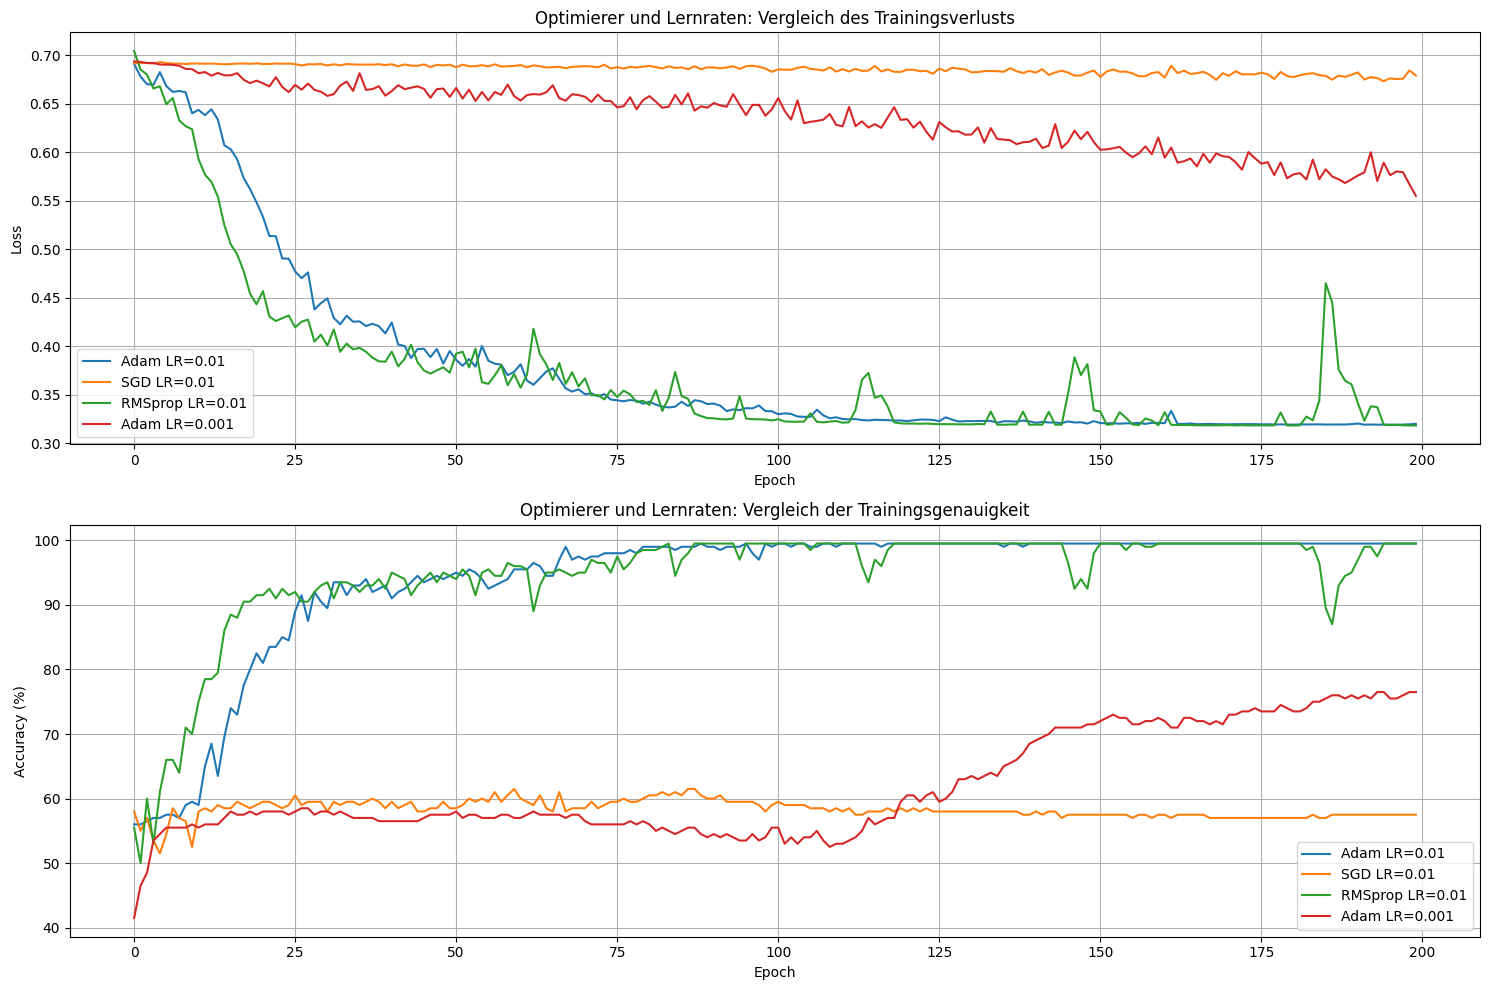

/Users/felix/Documents/education/dhbw/04-sose_25/ai_and_ml/programming/WDSKI_SOSE-Applied_ML_Fundamentals/exercise_6/utils_v2.py:62: UserWarning: You passed a edgecolor/edgecolors ('g') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolor='g', marker='x')


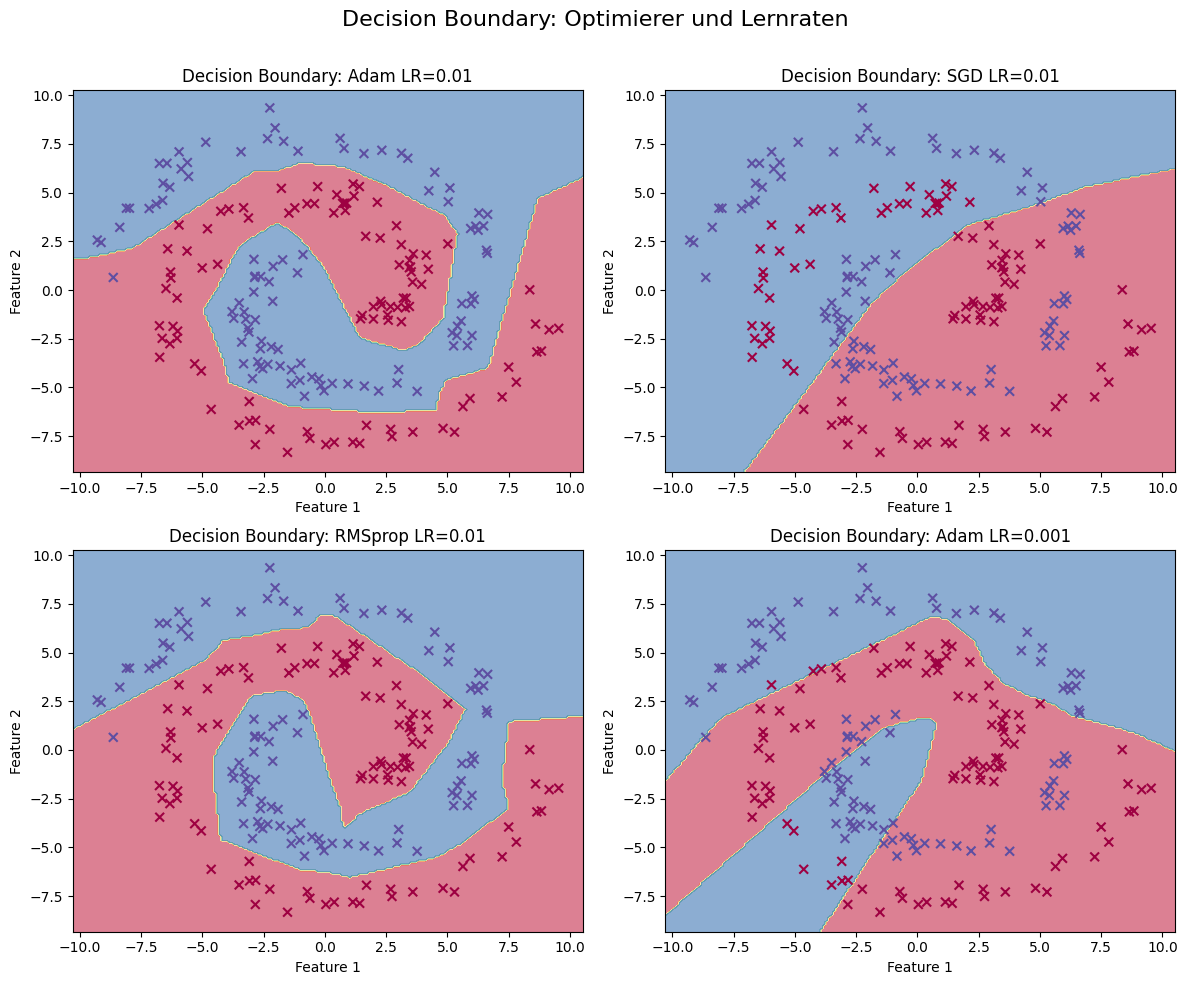

In [27]:
optimizer_results = compare_parameter_group(optimizers, dataset)
visualize_results(optimizer_results,X,y, "Optimierer und Lernraten")

In [ ]:
loss_results = compare_parameter_group(loss_functions, dataset)
visualize_results(loss_results,X,y, "Verlustfunktionen")

In [ ]:
batch_results = compare_parameter_group(batch_sizes, dataset)
visualize_results(batch_results,X,y, "Batch-Größen")

# **Q3 - its your turn now**

In [36]:
#Eigene Parameterkombination erstellen
custom_params = [
    {
        'name': 'Perfektes Modell',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],  
            'output_dim': 2,
            'activation': nn.ReLU()
        },
        'training_params': {
            'loss_fn': nn.MSELoss,
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,     
            'batch_size': 64,           
            'num_epochs': 200          
        }
    },
    {
        'name': 'Custom Modell',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [20, 10, 5,10,15,5],  
            'output_dim': 2,
            'activation': nn.Sigmoid()  
        },
        'training_params': {
            'loss_fn': nn.CrossEntropyLoss,
            'optimizer_fn': optim.RMSprop,
            'learning_rate': 0.002,
            'batch_size': 32,
            'num_epochs': 2000
        }
    }
]


Training mit Perfektes Modell...
Epoch [50/200], Loss: 0.0364, Accuracy: 96.50%
Epoch [100/200], Loss: 0.0057, Accuracy: 100.00%
Epoch [150/200], Loss: 0.0016, Accuracy: 100.00%
Epoch [200/200], Loss: 0.0017, Accuracy: 100.00%
Training für Perfektes Modell abgeschlossen!

Training mit Custom Modell...
Epoch [50/2000], Loss: 0.6934, Accuracy: 46.00%
Epoch [100/2000], Loss: 0.6922, Accuracy: 50.00%
Epoch [150/2000], Loss: 0.5457, Accuracy: 82.00%
Epoch [200/2000], Loss: 0.4686, Accuracy: 85.00%
Epoch [250/2000], Loss: 0.4692, Accuracy: 85.00%
Epoch [300/2000], Loss: 0.4368, Accuracy: 86.50%
Epoch [350/2000], Loss: 0.4442, Accuracy: 87.00%
Epoch [400/2000], Loss: 0.4332, Accuracy: 87.00%
Epoch [450/2000], Loss: 0.4303, Accuracy: 87.00%
Epoch [500/2000], Loss: 0.4570, Accuracy: 87.00%
Epoch [550/2000], Loss: 0.4431, Accuracy: 87.00%
Epoch [600/2000], Loss: 0.4297, Accuracy: 87.00%
Epoch [650/2000], Loss: 0.4648, Accuracy: 84.50%
Epoch [700/2000], Loss: 0.4431, Accuracy: 85.50%
Epoch [750/

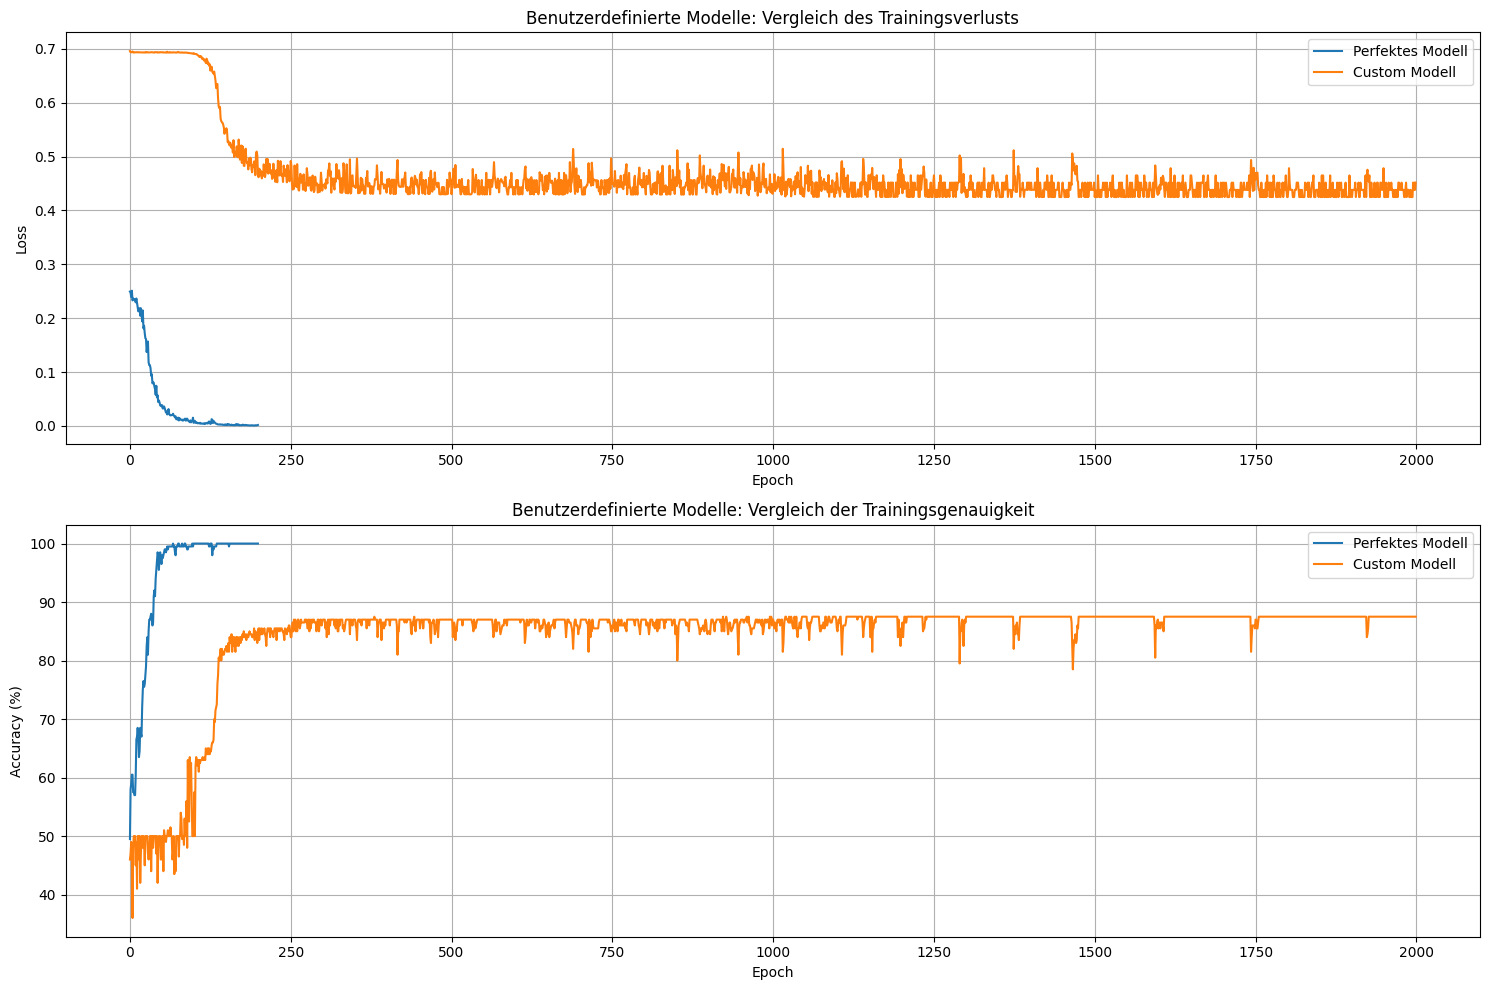

/Users/felix/Documents/education/dhbw/04-sose_25/ai_and_ml/programming/WDSKI_SOSE-Applied_ML_Fundamentals/exercise_6/utils_v2.py:62: UserWarning: You passed a edgecolor/edgecolors ('g') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolor='g', marker='x')


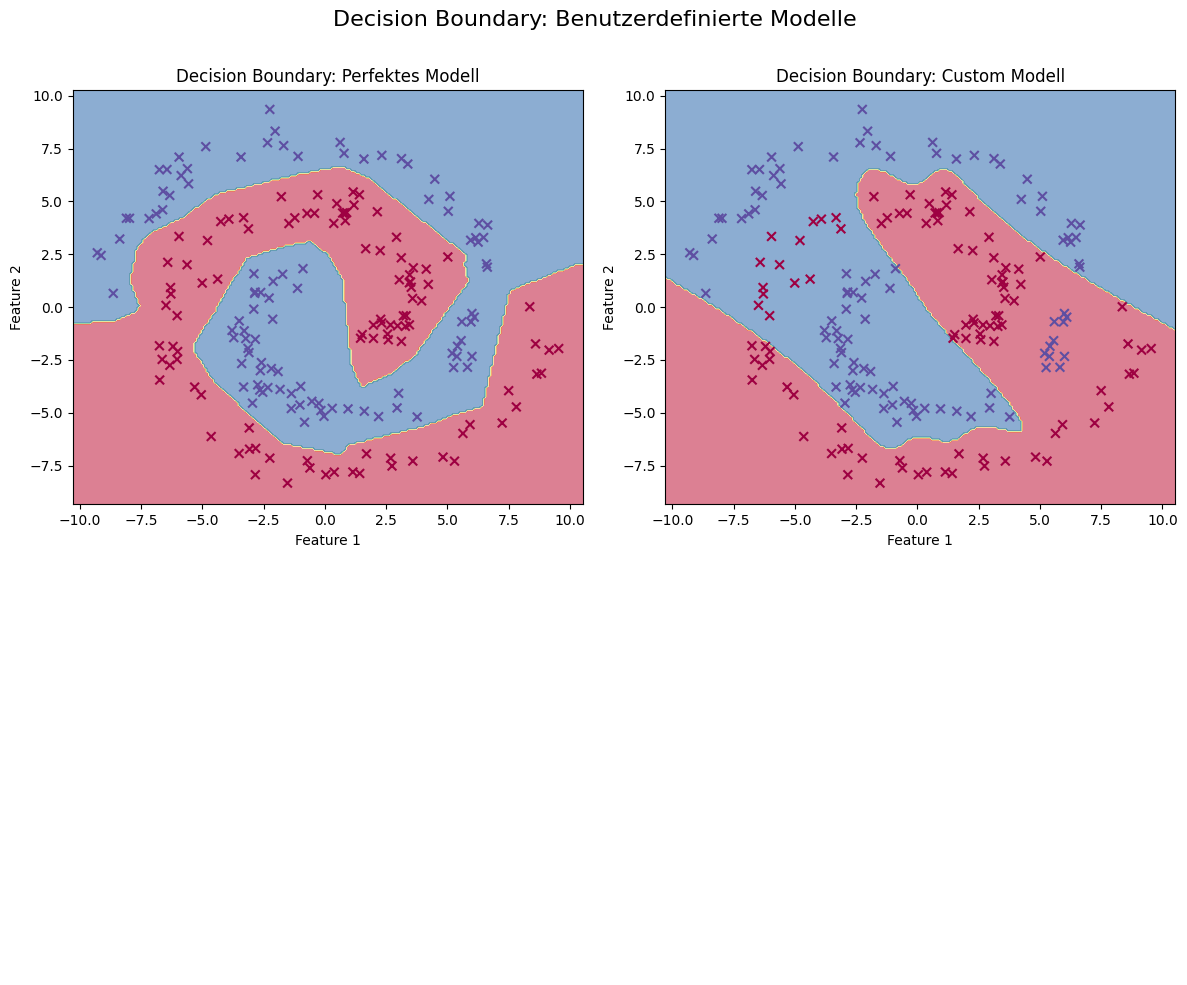

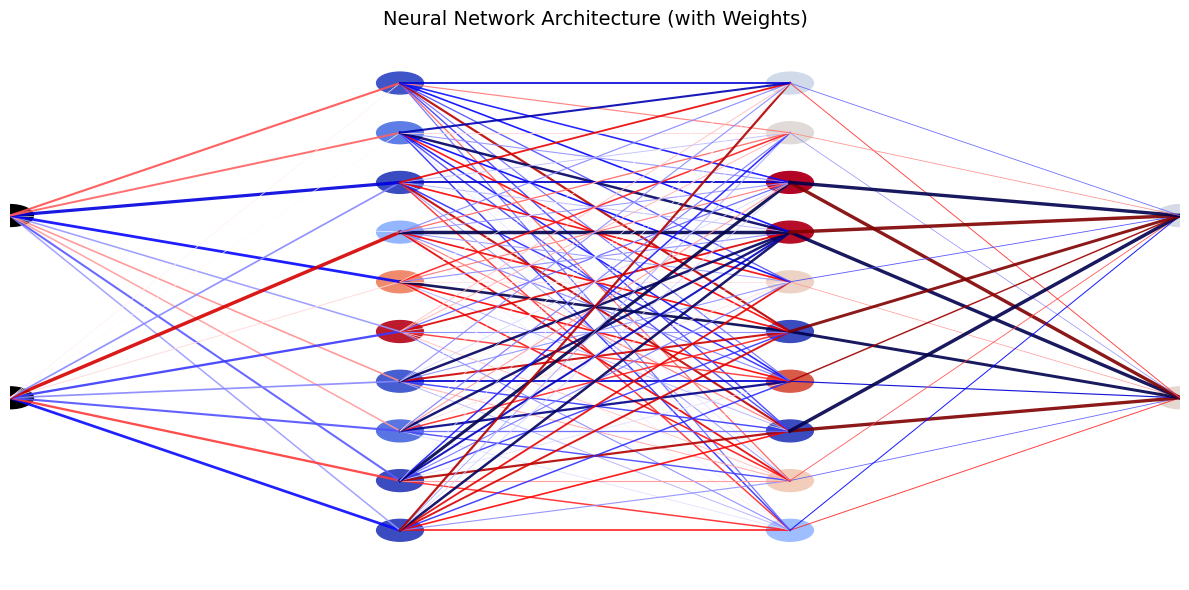

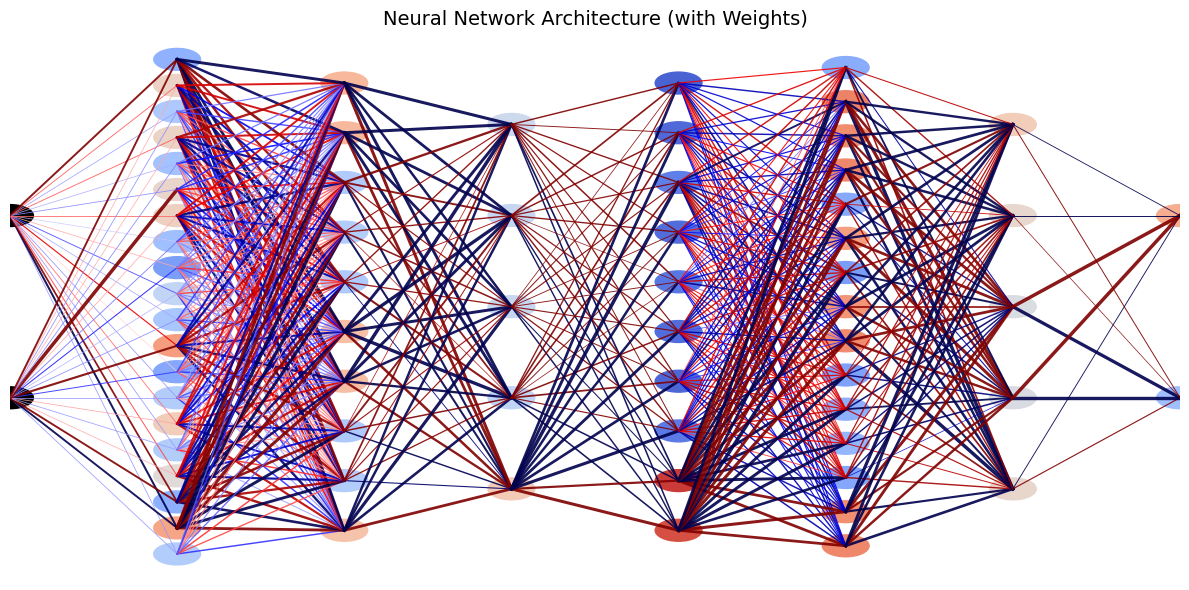

In [37]:
custom_results = []
for param_set in custom_params:
    print(f"\nTraining mit {param_set['name']}...")
    model, history = train_flexible_model(
        param_set.get('model_params', {}),
        param_set.get('training_params', {}),
        dataset
    )
    custom_results.append({
        'params': param_set,
        'model': model,
        'history': history
    })
    print(f"Training für {param_set['name']} abgeschlossen!")

visualize_results(custom_results, X,y, "Benutzerdefinierte Modelle")
draw_mlp_network(
    custom_results[0]['model'],
    #architecture_dict=custom_params[0]['model_params'],
    show_weights=True
)
draw_mlp_network(
    custom_results[1]['model'],
    #architecture_dict=custom_params[1]['model_params'],
    show_weights=True
)